# **PPO**

In [1]:
import numpy as np
import gymnasium as gym
from coverage_env import CoverageEnv
from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy

from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import os
import matplotlib.pyplot as plt

In [2]:
env_0 = CoverageEnv(curriculum=0)
env_1 = CoverageEnv(curriculum=1)
env_2 = CoverageEnv(curriculum=2)
env_3 = CoverageEnv(curriculum=3)
env_4 = CoverageEnv(curriculum=4)

# **Environment 0**

In [3]:
model = PPO(
    "MlpPolicy",
    env_0,
    learning_rate = 1e-4,
    n_steps       = 2048,
    batch_size    = 64,
    n_epochs      = 10,
    gamma         = 0.99,
    gae_lambda    = 0.95,
    clip_range    = 0.2,
    ent_coef      = 0.01,
    vf_coef       = 0.5,
    max_grad_norm = 0.5,
    verbose       = 1,
    tensorboard_log="logs/ppo/mlp/no_l2/coverage_lvl0",
)

# train for 50k timesteps
model.learn(total_timesteps=500_000)

# save it
model.save("models/ppo/no_l2/mlp_coverage_lvl0")


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to logs/ppo/mlp/no_l2/coverage_lvl0/PPO_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 165      |
|    ep_rew_mean     | -129     |
| time/              |          |
|    fps             | 6095     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 179         |
|    ep_rew_mean          | -151        |
| time/                   |             |
|    fps                  | 3592        |
|    iterations           | 2           |
|    time_elapsed         | 1           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.007317734 |
|    clip_fraction        | 0.00698     |
|    clip_ra

/Users/pedropertusi/Desktop/reinforcement-learning/Coverage-Path-Planning/env/lib/python3.12/site-packages/stable_baselines3/common/save_util.py:284: UserWarning: Path 'models/ppo/no_l2' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


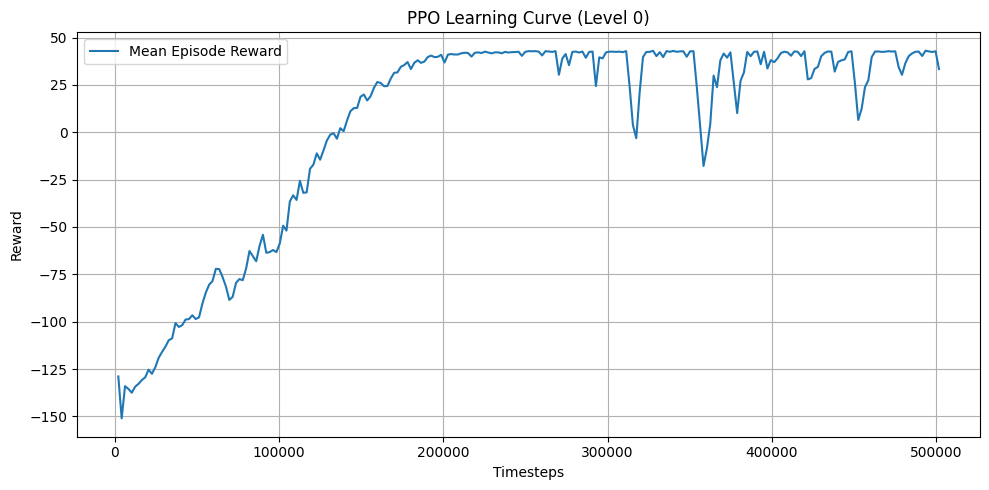

In [4]:
log_dir = "logs/ppo/mlp/no_l2/coverage_lvl0/PPO_1"
run_id = os.listdir(log_dir)[0]
event_path = os.path.join(log_dir, run_id)

# Load the TensorBoard logs
event_acc = EventAccumulator(event_path)
event_acc.Reload()

# Get 'rollout/ep_rew_mean' scalar events
rewards = event_acc.Scalars("rollout/ep_rew_mean")

# Extract steps and reward values
steps = [event.step for event in rewards]
reward_values = [event.value for event in rewards]

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(steps, reward_values, label="Mean Episode Reward")
plt.xlabel("Timesteps")
plt.ylabel("Reward")
plt.title("PPO Learning Curve (Level 0)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [5]:
mean_reward, std_reward = evaluate_policy(
    model,
    env_0,
    n_eval_episodes=20,
    deterministic=True,
)
print(f"Mean reward: {mean_reward:.2f} ± {std_reward:.2f}")

/Users/pedropertusi/Desktop/reinforcement-learning/Coverage-Path-Planning/env/lib/python3.12/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Mean reward: -1.15 ± 88.93


# **Environment 1**

In [6]:
# Load the pretrained model from curriculum 0
model = PPO.load(
    "models/ppo/no_l2/mlp_coverage_lvl0.zip", 
    env=env_1, 
    learning_rate = 1e-4,
    n_steps       = 2048,
    batch_size    = 64,
    n_epochs      = 10,
    gamma         = 0.99,
    gae_lambda    = 0.95,
    clip_range    = 0.2,
    ent_coef      = 0.01,
    vf_coef       = 0.5,
    max_grad_norm = 0.5,
    verbose       = 1,
    tensorboard_log="logs/ppo/mlp/no_l2/coverage_lvl1",
    # Let the model continue training to see if it carries the learning
    exploration_initial_eps=0.05,
    exploration_final_eps=0.05,
)

# Evaluate the model
mean_reward, std_reward = evaluate_policy(
    model, 
    env_1, 
    n_eval_episodes=20, 
    deterministic=True,
)
print(f"Mean reward: {mean_reward:.2f} ± {std_reward:.2f}")

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Mean reward: -198.95 ± 3.19


In [7]:
# Continue training on level 1
model.learn(total_timesteps=500_000)

# Save the fine-tuned model
model.save("models/ppo/no_l2/mlp_coverage_lvl1")

Logging to logs/ppo/mlp/no_l2/coverage_lvl1/PPO_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 200      |
|    ep_rew_mean     | -196     |
| time/              |          |
|    fps             | 6963     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 2048     |
---------------------------------
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 200           |
|    ep_rew_mean          | -197          |
| time/                   |               |
|    fps                  | 4026          |
|    iterations           | 2             |
|    time_elapsed         | 1             |
|    total_timesteps      | 4096          |
| train/                  |               |
|    approx_kl            | 0.00016164355 |
|    clip_fraction        | 0.00332       |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.0188   

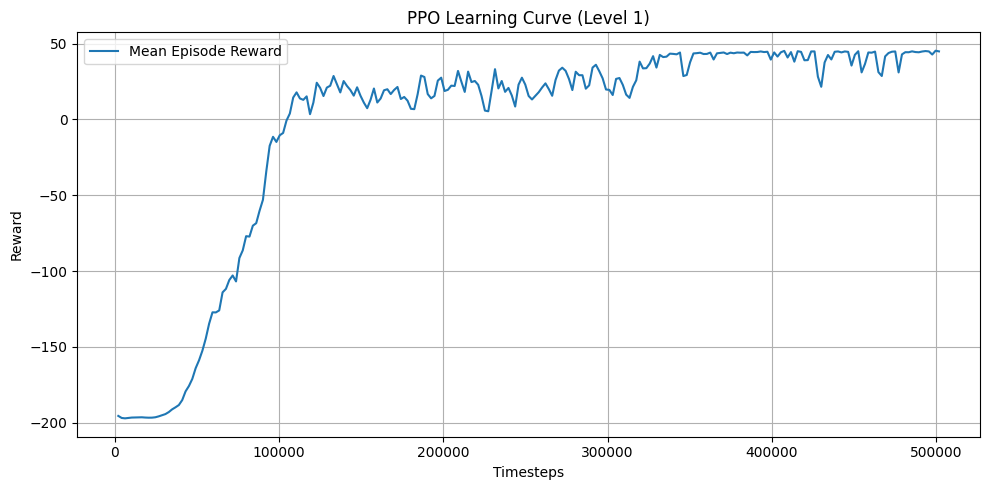

In [8]:
log_dir = "logs/ppo/mlp/no_l2/coverage_lvl1/PPO_1"
run_id = os.listdir(log_dir)[0]
event_path = os.path.join(log_dir, run_id)

# Load the TensorBoard logs
event_acc = EventAccumulator(event_path)
event_acc.Reload()

# Get 'rollout/ep_rew_mean' scalar events
rewards = event_acc.Scalars("rollout/ep_rew_mean")

# Extract steps and reward values
steps = [event.step for event in rewards]
reward_values = [event.value for event in rewards]

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(steps, reward_values, label="Mean Episode Reward")
plt.xlabel("Timesteps")
plt.ylabel("Reward")
plt.title("PPO Learning Curve (Level 1)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [9]:
mean_reward, std_reward = evaluate_policy(
    model,
    env_0,
    n_eval_episodes=20,
    deterministic=True,
)
print(f"Fine-tuned performance on level 0: {mean_reward:.2f} ± {std_reward:.2f}")

mean_reward, std_reward = evaluate_policy(
    model,
    env_1,
    n_eval_episodes=20,
    deterministic=True,
)
print(f"Fine-tuned performance on level 1: {mean_reward:.2f} ± {std_reward:.2f}")


mean_reward, std_reward = evaluate_policy(
    model,
    env_2,
    n_eval_episodes=20,
    deterministic=True,
)
print(f"Fine-tuned performance on level 2: {mean_reward:.2f} ± {std_reward:.2f}")

mean_reward, std_reward = evaluate_policy(
    model,
    env_3,
    n_eval_episodes=20,
    deterministic=True,
)
print(f"Fine-tuned performance on level 3: {mean_reward:.2f} ± {std_reward:.2f}")

mean_reward, std_reward = evaluate_policy(
    model,
    env_4,
    n_eval_episodes=20,
    deterministic=True,
)
print(f"Fine-tuned performance on level 4: {mean_reward:.2f} ± {std_reward:.2f}")

Fine-tuned performance on level 0: -192.65 ± 8.02
Fine-tuned performance on level 1: 32.70 ± 53.41
Fine-tuned performance on level 2: -200.00 ± 0.00
Fine-tuned performance on level 3: -198.20 ± 4.49
Fine-tuned performance on level 4: -198.95 ± 1.96


# **Environment 2**

In [10]:
# Load the pretrained model from curriculum 0
model = PPO.load(
    "models/ppo/no_l2/mlp_coverage_lvl1.zip", 
    env=env_2, 
    learning_rate = 1e-4,
    n_steps       = 2048,
    batch_size    = 64,
    n_epochs      = 10,
    gamma         = 0.99,
    gae_lambda    = 0.95,
    clip_range    = 0.2,
    ent_coef      = 0.01,
    vf_coef       = 0.5,
    max_grad_norm = 0.5,
    verbose       = 1,
    tensorboard_log="logs/ppo/mlp/no_l2/coverage_lvl2",
    # Let the model continue training to see if it carries the learning
    exploration_initial_eps=0.05,
    exploration_final_eps=0.05,
)

# Evaluate the model
mean_reward, std_reward = evaluate_policy(
    model, 
    env_2, 
    n_eval_episodes=20, 
    deterministic=True,
)
print(f"Mean reward: {mean_reward:.2f} ± {std_reward:.2f}")

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Mean reward: -200.00 ± 0.00


In [11]:
# Continue training on level 1
model.learn(total_timesteps=500_000)

# Save the fine-tuned model
model.save("models/ppo/no_l2/mlp_coverage_lvl2")

Logging to logs/ppo/mlp/no_l2/coverage_lvl2/PPO_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 200      |
|    ep_rew_mean     | -200     |
| time/              |          |
|    fps             | 6675     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 200         |
|    ep_rew_mean          | -200        |
| time/                   |             |
|    fps                  | 3672        |
|    iterations           | 2           |
|    time_elapsed         | 1           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.033208936 |
|    clip_fraction        | 0.00962     |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.00911    |
|    explained_varianc

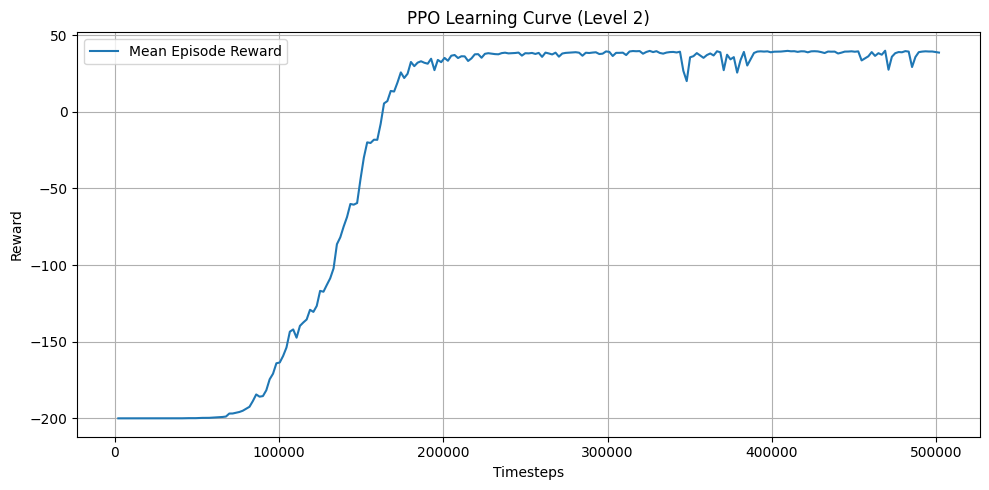

In [12]:
log_dir = "logs/ppo/mlp/no_l2/coverage_lvl2/PPO_1"
run_id = os.listdir(log_dir)[0]
event_path = os.path.join(log_dir, run_id)

# Load the TensorBoard logs
event_acc = EventAccumulator(event_path)
event_acc.Reload()

# Get 'rollout/ep_rew_mean' scalar events
rewards = event_acc.Scalars("rollout/ep_rew_mean")

# Extract steps and reward values
steps = [event.step for event in rewards]
reward_values = [event.value for event in rewards]

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(steps, reward_values, label="Mean Episode Reward")
plt.xlabel("Timesteps")
plt.ylabel("Reward")
plt.title("PPO Learning Curve (Level 2)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [13]:
mean_reward, std_reward = evaluate_policy(
    model,
    env_0,
    n_eval_episodes=20,
    deterministic=True,
)
print(f"Fine-tuned performance on level 0: {mean_reward:.2f} ± {std_reward:.2f}")

mean_reward, std_reward = evaluate_policy(
    model,
    env_1,
    n_eval_episodes=20,
    deterministic=True,
)
print(f"Fine-tuned performance on level 1: {mean_reward:.2f} ± {std_reward:.2f}")


mean_reward, std_reward = evaluate_policy(
    model,
    env_2,
    n_eval_episodes=20,
    deterministic=True,
)
print(f"Fine-tuned performance on level 2: {mean_reward:.2f} ± {std_reward:.2f}")

mean_reward, std_reward = evaluate_policy(
    model,
    env_3,
    n_eval_episodes=20,
    deterministic=True,
)
print(f"Fine-tuned performance on level 3: {mean_reward:.2f} ± {std_reward:.2f}")

mean_reward, std_reward = evaluate_policy(
    model,
    env_4,
    n_eval_episodes=20,
    deterministic=True,
)
print(f"Fine-tuned performance on level 4: {mean_reward:.2f} ± {std_reward:.2f}")

Fine-tuned performance on level 0: -197.30 ± 3.41
Fine-tuned performance on level 1: -193.55 ± 7.61
Fine-tuned performance on level 2: 29.45 ± 49.94
Fine-tuned performance on level 3: -200.00 ± 0.00
Fine-tuned performance on level 4: -200.00 ± 0.00


# **Environment 3**

In [14]:
# Load the pretrained model from curriculum 0
model = PPO.load(
    "models/ppo/no_l2/mlp_coverage_lvl2.zip", 
    env=env_3, 
    learning_rate = 1e-4,
    n_steps       = 2048,
    batch_size    = 64,
    n_epochs      = 10,
    gamma         = 0.99,
    gae_lambda    = 0.95,
    clip_range    = 0.2,
    ent_coef      = 0.01,
    vf_coef       = 0.5,
    max_grad_norm = 0.5,
    verbose       = 1,
    tensorboard_log="logs/ppo/mlp/no_l2/coverage_lvl3",
    # Let the model continue training to see if it carries the learning
    exploration_initial_eps=0.05,
    exploration_final_eps=0.05,
)

# Evaluate the model
mean_reward, std_reward = evaluate_policy(
    model, 
    env_3, 
    n_eval_episodes=20,
    deterministic=True,
)
print(f"Mean reward: {mean_reward:.2f} ± {std_reward:.2f}")

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Mean reward: -199.25 ± 3.27


In [15]:
# Continue training on level 1
model.learn(total_timesteps=500_000)

# Save the fine-tuned model
model.save("models/ppo/no_l2/mlp_coverage_lvl3")

Logging to logs/ppo/mlp/no_l2/coverage_lvl3/PPO_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 200      |
|    ep_rew_mean     | -199     |
| time/              |          |
|    fps             | 6053     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 2048     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 200          |
|    ep_rew_mean          | -199         |
| time/                   |              |
|    fps                  | 3782         |
|    iterations           | 2            |
|    time_elapsed         | 1            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0028092342 |
|    clip_fraction        | 0.0148       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0592      |
|    exp

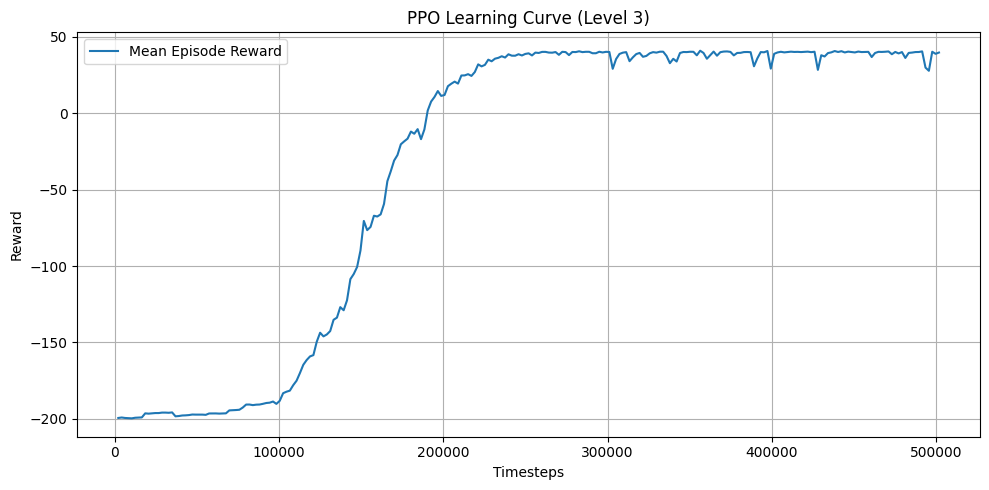

In [16]:
log_dir = "logs/ppo/mlp/no_l2/coverage_lvl3/PPO_1"
run_id = os.listdir(log_dir)[0]
event_path = os.path.join(log_dir, run_id)

# Load the TensorBoard logs
event_acc = EventAccumulator(event_path)
event_acc.Reload()

# Get 'rollout/ep_rew_mean' scalar events
rewards = event_acc.Scalars("rollout/ep_rew_mean")

# Extract steps and reward values
steps = [event.step for event in rewards]
reward_values = [event.value for event in rewards]

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(steps, reward_values, label="Mean Episode Reward")
plt.xlabel("Timesteps")
plt.ylabel("Reward")
plt.title("PPO Learning Curve (Level 3)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [17]:
mean_reward, std_reward = evaluate_policy(
    model,
    env_0,
    n_eval_episodes=20,
    deterministic=True,
)
print(f"Fine-tuned performance on level 0: {mean_reward:.2f} ± {std_reward:.2f}")

mean_reward, std_reward = evaluate_policy(
    model,
    env_1,
    n_eval_episodes=20,
    deterministic=True,
)
print(f"Fine-tuned performance on level 1: {mean_reward:.2f} ± {std_reward:.2f}")


mean_reward, std_reward = evaluate_policy(
    model,
    env_2,
    n_eval_episodes=20,
    deterministic=True,
)
print(f"Fine-tuned performance on level 2: {mean_reward:.2f} ± {std_reward:.2f}")

mean_reward, std_reward = evaluate_policy(
    model,
    env_3,
    n_eval_episodes=20,
    deterministic=True,
)
print(f"Fine-tuned performance on level 3: {mean_reward:.2f} ± {std_reward:.2f}")

mean_reward, std_reward = evaluate_policy(
    model,
    env_4,
    n_eval_episodes=20,
    deterministic=True,
)
print(f"Fine-tuned performance on level 4: {mean_reward:.2f} ± {std_reward:.2f}")

Fine-tuned performance on level 0: -194.45 ± 2.38
Fine-tuned performance on level 1: -196.10 ± 6.23
Fine-tuned performance on level 2: -199.55 ± 1.96
Fine-tuned performance on level 3: 40.55 ± 2.20
Fine-tuned performance on level 4: -200.00 ± 0.00


# **Environment 4**

In [18]:
# Load the pretrained model from curriculum 0
model = PPO.load(
    "models/ppo/no_l2/mlp_coverage_lvl3.zip", 
    env=env_4, 
    learning_rate = 1e-4,
    n_steps       = 2048,
    batch_size    = 64,
    n_epochs      = 10,
    gamma         = 0.99,
    gae_lambda    = 0.95,
    clip_range    = 0.2,
    ent_coef      = 0.01,
    vf_coef       = 0.5,
    max_grad_norm = 0.5,
    verbose       = 1,
    tensorboard_log="logs/ppo/mlp/no_l2/coverage_lvl4",
    # Let the model continue training to see if it carries the learning
    exploration_initial_eps=0.05,
    exploration_final_eps=0.05,
)

# Evaluate the model
mean_reward, std_reward = evaluate_policy(
    model, 
    env_4, 
    n_eval_episodes=20,
    deterministic=True,
)
print(f"Mean reward: {mean_reward:.2f} ± {std_reward:.2f}")

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Mean reward: -200.00 ± 0.00


In [19]:
# Continue training on level 1
model.learn(total_timesteps=500_000)

# Save the fine-tuned model
model.save("models/ppo/no_l2/mlp_coverage_lv4")

Logging to logs/ppo/mlp/no_l2/coverage_lvl4/PPO_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 200      |
|    ep_rew_mean     | -200     |
| time/              |          |
|    fps             | 6705     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 200         |
|    ep_rew_mean          | -200        |
| time/                   |             |
|    fps                  | 3929        |
|    iterations           | 2           |
|    time_elapsed         | 1           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.007816962 |
|    clip_fraction        | 0.0592      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0918     |
|    explained_varianc

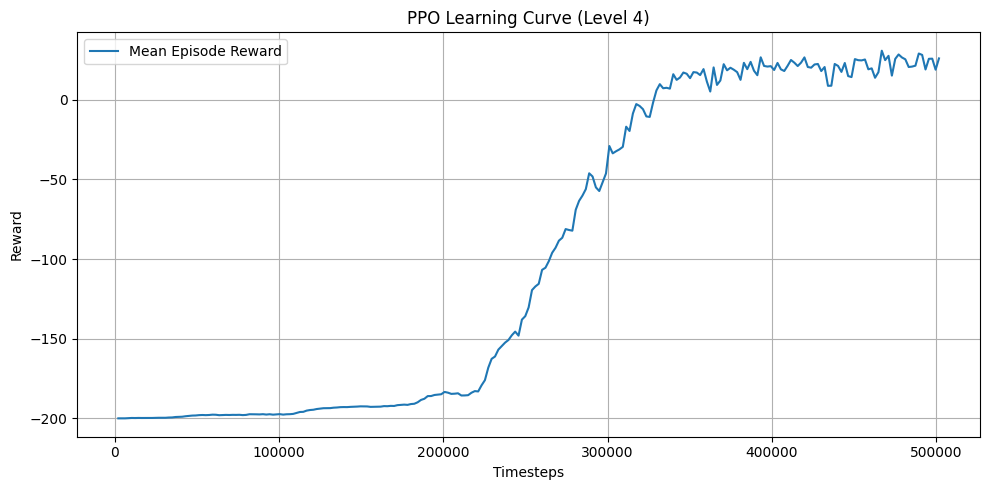

In [20]:
log_dir = "logs/ppo/mlp/no_l2/coverage_lvl4/PPO_1"
run_id = os.listdir(log_dir)[0]
event_path = os.path.join(log_dir, run_id)

# Load the TensorBoard logs
event_acc = EventAccumulator(event_path)
event_acc.Reload()

# Get 'rollout/ep_rew_mean' scalar events
rewards = event_acc.Scalars("rollout/ep_rew_mean")

# Extract steps and reward values
steps = [event.step for event in rewards]
reward_values = [event.value for event in rewards]

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(steps, reward_values, label="Mean Episode Reward")
plt.xlabel("Timesteps")
plt.ylabel("Reward")
plt.title("PPO Learning Curve (Level 4)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [21]:
mean_reward, std_reward = evaluate_policy(
    model,
    env_0,
    n_eval_episodes=20,
    deterministic=True,
)
print(f"Fine-tuned performance on level 0: {mean_reward:.2f} ± {std_reward:.2f}")

mean_reward, std_reward = evaluate_policy(
    model,
    env_1,
    n_eval_episodes=20,
    deterministic=True,
)
print(f"Fine-tuned performance on level 1: {mean_reward:.2f} ± {std_reward:.2f}")


mean_reward, std_reward = evaluate_policy(
    model,
    env_2,
    n_eval_episodes=20,
    deterministic=True,
)
print(f"Fine-tuned performance on level 2: {mean_reward:.2f} ± {std_reward:.2f}")

mean_reward, std_reward = evaluate_policy(
    model,
    env_3,
    n_eval_episodes=20,
    deterministic=True,
)
print(f"Fine-tuned performance on level 3: {mean_reward:.2f} ± {std_reward:.2f}")

mean_reward, std_reward = evaluate_policy(
    model,
    env_4,
    n_eval_episodes=20,
    deterministic=True,
)
print(f"Fine-tuned performance on level 4: {mean_reward:.2f} ± {std_reward:.2f}")

Fine-tuned performance on level 0: -196.55 ± 4.77
Fine-tuned performance on level 1: -197.45 ± 3.94
Fine-tuned performance on level 2: -200.00 ± 0.00
Fine-tuned performance on level 3: -199.40 ± 1.80
Fine-tuned performance on level 4: 29.65 ± 2.52


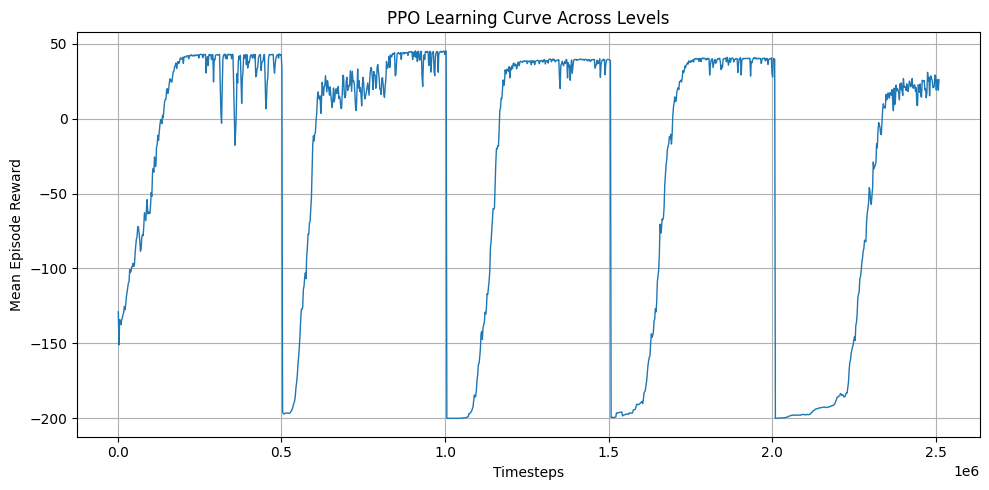

In [22]:
log_dir = "logs/ppo/mlp/no_l2"

run_dirs = sorted(
    [d for d in os.listdir(log_dir) if d.startswith("coverage_")],
    key=lambda x: int(x.split("lvl")[-1])
)

all_steps, all_rewards = [], []
offset = 0


for run in run_dirs:
    path = os.path.join(log_dir, run, "PPO_1")
    ea = EventAccumulator(path)
    ea.Reload()
    scalars = ea.Scalars("rollout/ep_rew_mean")
    steps  = [e.step  for e in scalars]
    rewards= [e.value for e in scalars]

    shifted = [s + offset for s in steps]

    all_steps  += shifted
    all_rewards+= rewards

    offset += max(steps)

plt.figure(figsize=(10,5))
plt.plot(all_steps, all_rewards, linewidth=1)
plt.xlabel("Timesteps")
plt.ylabel("Mean Episode Reward")
plt.title("PPO Learning Curve Across Levels")
plt.grid(True)
plt.tight_layout()
plt.show()